## MNIST Handwritten Digit Recognition

![Example of the dataset](img/mnist_plot.png)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt

In [38]:
NUM_PIXELS = 28*28

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(NUM_PIXELS, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(16*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

In [39]:
BATCH_SIZE = 32

def fit(model: nn.Module, train_loader: torch.utils.data.DataLoader, flatten: bool = True):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    
    # Train Network
    model.train()

    for epoch in range(EPOCHS):  
    # 1 epoch => Network has seen all the images in the dataset
        
        print(f'Epoch: {epoch}')

        for batch_idx, (data, targets) in enumerate(train_loader):
            if flatten:
                data = data.reshape(data.shape[0], -1)  # Flatten
            if epoch == 0 and batch_idx == 0:
                print(data.shape)

            # forward
            scores = model(data)

            loss = error(scores, targets)

            # backward
            optimizer.zero_grad()  # set all gradients to zero for each batch
            loss.backward()

            # gradient descent
            optimizer.step()

In [42]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

image, label = trainset[1]

Epoch: 0
torch.Size([32, 784])
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


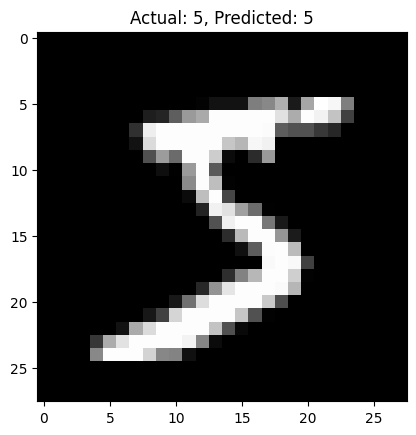

In [ ]:
mlp_model = MLP()

fit(mlp_model, trainloader)

mlp_model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(mlp_model(image.reshape(-1, NUM_PIXELS))).item()}")
    plt.show()

Epoch: 0
torch.Size([32, 1, 28, 28])
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x49 and 784x10)

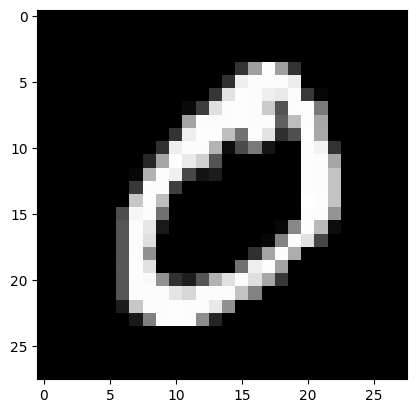

In [43]:
conv_model = CNN()

fit(conv_model, trainloader, flatten=False)

conv_model.eval()
with torch.no_grad():  # dont compute gradients
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Actual: {label}, Predicted: {torch.argmax(conv_model(image)).item()}")
    plt.show()

In [ ]:
print(image.shape)

conv_model.eval()
with torch.no_grad():  # dont compute gradients
    conv_model(image).shape

torch.Size([1, 28, 28])


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
